In [37]:
import pandas as pd
import os
import glob
import re
import numpy as np
from scipy.stats import mode, entropy

In [38]:
# Define the folder path
folder_path = r"C:\Users\USAID\OneDrive - American University of Beirut\Tamara S\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\RF_first_try\features"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Check if files exist
if not csv_files:
    print("No CSV files found in the directory.")
else:
    # Loop through files and extract Patient ID and Wrist Side
    for file_path in csv_files:
        filename = os.path.basename(file_path)
        
        # Updated regex to match filenames like Features_P11_RW.csv or Features_P11_LW_new.csv
        match = re.search(r'P(\d+)_([RL]W\d?|[RL]W)', filename)
        if match:
            patient_id = match.group(1)
            wrist_side = match.group(2)
            print(f"File: {filename} | Patient ID: {patient_id} | Wrist Side: {wrist_side}")
        else:
            print(f"Filename format not recognized: {filename}")

    # Display the columns of the first CSV file
    first_df = pd.read_csv(csv_files[0])
    print("\nColumns in the feature files:")
    display(first_df.columns)
print(f"Number of CSV files found: {len(csv_files)}")


File: Features_P11_LW_new.csv | Patient ID: 11 | Wrist Side: LW
File: Features_P11_RW_new.csv | Patient ID: 11 | Wrist Side: RW
File: Features_P12_LW.csv | Patient ID: 12 | Wrist Side: LW
File: Features_P12_RW.csv | Patient ID: 12 | Wrist Side: RW
File: Features_P13_LW.csv | Patient ID: 13 | Wrist Side: LW
File: Features_P13_RW.csv | Patient ID: 13 | Wrist Side: RW
File: Features_P15_LW.csv | Patient ID: 15 | Wrist Side: LW
File: Features_P15_RW.csv | Patient ID: 15 | Wrist Side: RW
File: Features_P18_RW_new.csv | Patient ID: 18 | Wrist Side: RW
File: Features_P1_RW2.csv | Patient ID: 1 | Wrist Side: RW2
File: Features_P22_LW.csv | Patient ID: 22 | Wrist Side: LW
File: Features_P22_RW.csv | Patient ID: 22 | Wrist Side: RW
File: Features_P24_LW2.csv | Patient ID: 24 | Wrist Side: LW2
File: Features_P27_LW2.csv | Patient ID: 27 | Wrist Side: LW2
File: Features_P27_RW2.csv | Patient ID: 27 | Wrist Side: RW2
File: Features_P29_LW2.csv | Patient ID: 29 | Wrist Side: LW2
File: Features_P29_R

Index(['Mode', 'Median', 'MaxAbs', 'LineLength', '10thQuantile',
       '75thQuantile', 'NonLinearEnergy', 'SVD_Entropy', 'ShannonEntropy',
       'Average EDA per epoch', 'EDR_count', 'Storm_mark', 'Sleep_stage',
       'Age', 'Gender', 'Date_E4_synced', 'time_since_storm_start',
       'time_since_last_storm', 'ACC_mean', 'BVP_mean', 'HR_mean', 'TEMP_mean',
       'Date_E4_TZ', 'Date_E4_synced_str'],
      dtype='object')

Number of CSV files found: 49


In [39]:
cleaned_eda_folder = r"C:\Users\USAID\OneDrive - American University of Beirut\Tamara S\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\Cleaned EDA input files"
output_folder = r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\features"
patient_info_file = r"C:\Users\USAID\OneDrive - American University of Beirut\Tamara S\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\Data.csv"

# Load patient info
df_patient_info = pd.read_csv(patient_info_file)
df_patient_info.set_index("Record ID", inplace=True)

# Feature extraction function
def extract_features(signal):
    if len(signal) == 0:
        return {key: np.nan for key in [
            "Mode", "Median", "MaxAbs", "LineLength", "10thQuantile", "75thQuantile",
            "NonLinearEnergy", "SVD_Entropy", "ShannonEntropy"
        ]}

    mode_result = mode(signal, nan_policy="omit")
    mode_value = mode_result.mode.item() if mode_result.mode.size > 0 else np.nan

    features = {
        "Mode": mode_value,
        "Median": np.median(signal),
        "MaxAbs": np.max(np.abs(signal)),
        "LineLength": np.sum(np.abs(np.diff(signal))),
        "10thQuantile": np.quantile(signal, 0.10),
        "75thQuantile": np.quantile(signal, 0.75),
        "NonLinearEnergy": np.sum(signal[:-2] * signal[1:-1] - signal[2:] ** 2) if len(signal) > 2 else np.nan,
    }

    # SVD Entropy
    if len(signal) > 1:
        U, S, V = np.linalg.svd(np.reshape(signal, (-1, 1)), full_matrices=False)
        if np.sum(S) > 0:
            S_norm = S / np.sum(S)
            features["SVD_Entropy"] = -np.sum(S_norm * np.log2(S_norm + 1e-10))
        else:
            features["SVD_Entropy"] = np.nan
    else:
        features["SVD_Entropy"] = np.nan

    # Shannon Entropy
    hist, _ = np.histogram(signal, bins=10, density=True)
    hist = hist + 1e-10  # avoid log(0)
    features["ShannonEntropy"] = entropy(hist, base=2)

    return features

# Storage for all patients
summary_rows = []

# Loop through cleaned EDA files
for file in os.listdir(cleaned_eda_folder):
    if file.startswith("EDA_") and file.endswith(".csv"):
        file_path = os.path.join(cleaned_eda_folder, file)
        
        # Extract Patient ID, e.g. P11_RW
        patient_id = file.replace("EDA_", "").replace(".csv", "")
        match = re.match(r'P(\d+)_([LR]W)', patient_id)
        if not match:
            print(f"Skipping file with unexpected format: {file}")
            continue
        
        patient_num = match.group(1)
        wrist = match.group(2)

        # Load EDA data (skip first 2 rows, no header)
        eda_df = pd.read_csv(file_path, header=None, skiprows=2, names=["EDA"])

        if "EDA" not in eda_df.columns:
            print(f"Skipping {file} — 'EDA' column not found.")
            continue

        eda_signal = eda_df["EDA"].values
        features = extract_features(eda_signal)

        # Add patient metadata
        features["Patient_ID"] = patient_id
        features["Patient_Num"] = patient_num
        features["Wrist"] = wrist

        try:
            numeric_id = int(patient_num)
            if numeric_id in df_patient_info.index:
                features["Age"] = df_patient_info.loc[numeric_id, "Age (Years)"]
                features["Gender"] = df_patient_info.loc[numeric_id, "Gender"]
            else:
                features["Age"] = None
                features["Gender"] = None
        except:
            features["Age"] = None
            features["Gender"] = None

        summary_rows.append(features)

# Create and save the final summary DataFrame
summary_df = pd.DataFrame(summary_rows)
os.makedirs(output_folder, exist_ok=True)
summary_output = os.path.join(output_folder, "Patient_Level_Features.csv")
summary_df.to_csv(summary_output, index=False)

print(f"✅ Saved patient-level features to: {summary_output}")

✅ Saved patient-level features to: C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\features\Patient_Level_Features.csv


In [46]:
pip install imbalanced-learn


You should consider upgrading via the 'c:\Users\USAID\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load data
features_df = pd.read_csv(r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\features\Patient_Level_Features.csv")
labels_df = pd.read_excel(r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\codes\patient_cluster_assignments.xlsx")

# Ensure consistent data types for merging
features_df['Patient_Num'] = features_df['Patient_Num'].astype(str)
labels_df['Patient_ID'] = labels_df['Patient_ID'].astype(str)

# Merge on patient number and ID
merged_df = pd.merge(features_df, labels_df, left_on='Patient_Num', right_on='Patient_ID')

# Drop irrelevant columns (corrected to match your actual column names)
X = merged_df.drop(columns=['Patient_ID_x', 'Patient_ID_y', 'Patient_Num', 'Wrist', 'Gender', 'Cluster', 'sleep_quality'], errors='ignore')
y = merged_df['Cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[6 2]
 [2 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           2       0.00      0.00      0.00         2

    accuracy                           0.60        10
   macro avg       0.38      0.38      0.38        10
weighted avg       0.60      0.60      0.60        10



In [81]:
# === Load Main EDA Features ===
eda_features = pd.read_csv(r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\features\Patient_Level_Features.csv")

# === Load Storm Features (and filter relevant columns only) ===
storm_features = pd.read_excel(
    r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\Final_Merged_Sleep_Storm_Spindle_SWA_Summary.xlsx",  # Replace with actual path
    usecols=[
        'PatientNumber', 'WristSide', 'storms_total', 'avg_storm_duration',
        'mean_total_EDRs', 'mean_EDRs_in_sleep', 'storms_in_N1', 'storms_in_N2',
        'storms_in_N3', 'storms_in_REM', 'storms_in_Wake'
    ]
)
# Convert all numerical columns to numeric (in case some are strings)
numeric_cols = [
    'storms_total', 'avg_storm_duration', 'mean_total_EDRs', 'mean_EDRs_in_sleep',
    'storms_in_N1', 'storms_in_N2', 'storms_in_N3', 'storms_in_REM', 'storms_in_Wake'
]

for col in numeric_cols:
    storm_features[col] = pd.to_numeric(storm_features[col], errors='coerce')
# === Standardize Column Types for Merge ===
eda_features['Patient_Num'] = eda_features['Patient_Num'].astype(str)
storm_features['PatientNumber'] = storm_features['PatientNumber'].astype(str)

# === Merge EDA + Storm Features on Patient and Wrist ===
combined_df = pd.merge(
    eda_features,
    storm_features,
    how='left',
    left_on=['Patient_Num', 'Wrist'],
    right_on=['PatientNumber', 'WristSide']
)

# Drop redundant columns
combined_df.drop(columns=['PatientNumber', 'WristSide'], inplace=True)

# === Save Combined Features to CSV ===
combined_df.to_csv(r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\features\Combined_Features.csv", index=False)
print("✅ Saved combined features.")

✅ Saved combined features.


In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# === Load the manually cleaned Combined_Features.csv ===
combined_df = pd.read_csv(r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\features\Combined_Features.csv")

# === Load the labels ===
labels_df = pd.read_excel(r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\codes\patient_cluster_assignments.xlsx")
# Drop Patient 76 from the labels



labels_df['Patient_ID'] = labels_df['Patient_ID'].astype(str)
labels_df = labels_df[labels_df['Patient_ID'] != '76']
# === Merge Combined Features with Labels ===
# Drop rows with missing patient numbers
combined_df = combined_df[combined_df['Patient_Num'].notna()]

# Now safely convert to int, then string to match labels
combined_df['Patient_Num'] = combined_df['Patient_Num'].astype(float).astype(int).astype(str)

combined_df['Patient_Num'] = combined_df['Patient_Num'].astype(float).astype(int).astype(str)
# Merge with labels
full_df = pd.merge(combined_df, labels_df, left_on='Patient_Num', right_on='Patient_ID')
# Drop rows with any NaN values before training
full_df = full_df.dropna()
# Drop rows with Cluster 1
full_df = full_df[full_df['Cluster'] != 1]

print("✅ After dropping Cluster 1:")
print(full_df['Cluster'].value_counts())


✅ After dropping Cluster 1:
Cluster
0    34
2    11
Name: count, dtype: int64


In [ ]:

new_features_df = pd.read_excel(r"C:\Users\USAID\OneDrive - American University of Beirut\EECE798K Project\N2N3storms_power_spindles2.xlsx", usecols=[
    'PatientNumber', 'WristSide',
    'N23_onset_storms', 'avg_storm_duration_N23',
    'mean_total_EDRs', 'mean_EDRs_in_sleep',
    'EDRs_1', 'EDRs_2', 'EDRs_3', 'EDRs_r', 'EDRs_W'
])

# Ensure all columns (except ID columns) are numeric
cols_to_convert = [
    'N23_onset_storms', 'avg_storm_duration_N23',
    'mean_total_EDRs', 'mean_EDRs_in_sleep',
    'EDRs_1', 'EDRs_2', 'EDRs_3', 'EDRs_r', 'EDRs_W'
]
for col in cols_to_convert:
    new_features_df[col] = pd.to_numeric(new_features_df[col], errors='coerce')

# Convert merge keys to the same type (string) to avoid dtype mismatch
full_df['Patient_Num'] = full_df['Patient_Num'].astype(str)
new_features_df['PatientNumber'] = new_features_df['PatientNumber'].astype(str)

# Merge using standardized key types
merged_full_df = pd.merge(
    full_df,
    new_features_df,
    left_on=['Patient_Num', 'Wrist'],
    right_on=['PatientNumber', 'WristSide'],
    how='left'
)

# Drop any unmatched/missing rows
merged_full_df.dropna(inplace=True)

# Drop redundant columns after merge
merged_full_df.drop(columns=['PatientNumber', 'WristSide'], inplace=True, errors='ignore')

# Final check
print("✅ Final merged shape:", merged_full_df.shape)



✅ Final merged shape: (44, 35)


In [101]:
# Define features and target
X = merged_full_df.drop(columns=['Patient_ID_x', 'Patient_ID_y', 'Patient_Num', 'Wrist', 'Gender', 'Cluster', 'sleep_quality'], errors='ignore')
y = merged_full_df['Cluster']

# Stratified split (now only Cluster 0 and 2)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


# Train classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))



📊 Confusion Matrix:
[[6 1]
 [1 1]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           2       0.50      0.50      0.50         2

    accuracy                           0.78         9
   macro avg       0.68      0.68      0.68         9
weighted avg       0.78      0.78      0.78         9



In [109]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# === Define Features and Target ===
X = merged_full_df.drop(columns=[
    'Patient_ID_x', 'Patient_ID_y', 'Patient_Num', 'Wrist', 'Gender', 'Cluster', 'sleep_quality'
], errors='ignore')
y = merged_full_df['Cluster']

# === Stratified Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define Hyperparameter Grid ===
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# === Initialize Random Forest Classifier ===
rf = RandomForestClassifier(random_state=42)

# === Grid Search with Cross-Validation ===
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# === Fit the Model ===
grid_search.fit(X_train, y_train)

# === Best Parameters and Estimator ===
print("✅ Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# === Predict and Evaluate ===
y_pred = best_rf.predict(X_test)

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

📊 Confusion Matrix:
[[6 1]
 [0 2]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           2       0.67      1.00      0.80         2

    accuracy                           0.89         9
   macro avg       0.83      0.93      0.86         9
weighted avg       0.93      0.89      0.90         9



In [107]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\USAID\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


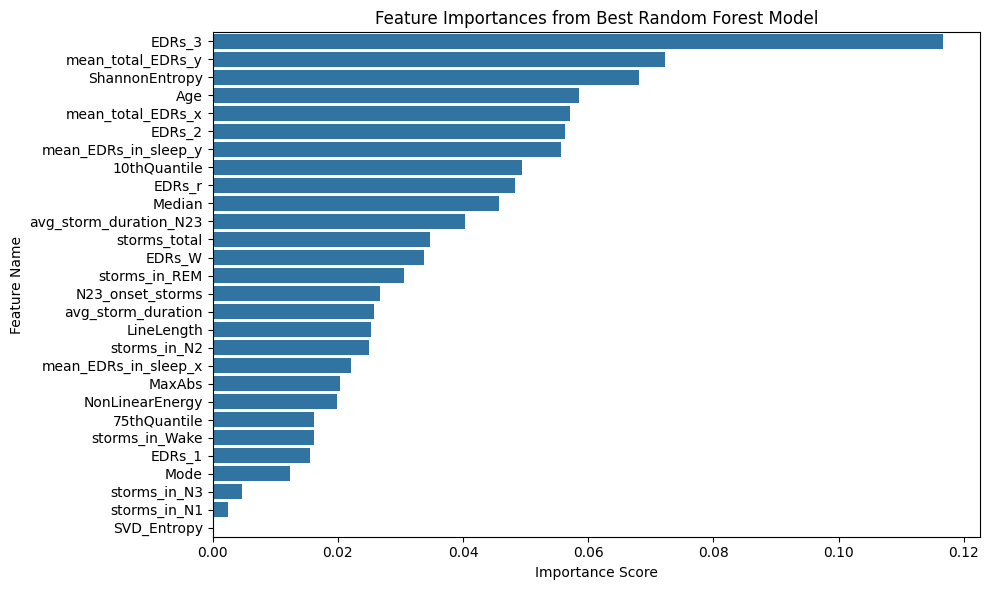

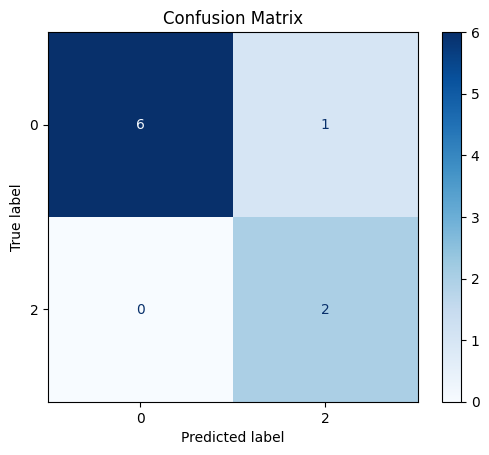

In [110]:
# === Feature Importances ===
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# === Plot Feature Importances ===
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Best Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# === Confusion Matrix Plot ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
